# Adding activity chains to synthetic populations 

The purpose of this script is to test different approaches to matching households in the synthetic population to a household from the [National Travel Survey (NTS)](https://beta.ukdataservice.ac.uk/datacatalogue/studies/study?id=5340). 

### Methods

1. categorical matching: joining on relevant socio-demographic variables
2. statistical matching, as described in [An unconstrained statistical matching algorithm for combining individual and household level geo-specific census and survey data](https://doi.org/10.1016/j.compenvurbsys.2016.11.003). 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from acbm.preprocessing import (
    count_per_group,
    match_coverage_col,
    nts_filter_by_region,
    nts_filter_by_year,
    num_adult_child_hh,
    transform_by_group,
    truncate_values,
)

pd.set_option('display.max_columns', None)

## Step 1: Load in the datasets  

### SPC 

In [2]:
# useful variables
region = "west-yorkshire"

In [3]:
# Read in the spc data (parquet format)
spc = pd.read_parquet('../data/external/spc_output/' + region + '_people_hh.parquet')
spc.head()

,id,household,workplace,location,events,weekday_diaries,weekend_diaries,orig_pid,id_tus_hh,id_tus_p,pid_hs,msoa,oa,members,bmi,has_cardiovascular_disease,has_diabetes,has_high_blood_pressure,number_medications,self_assessed_health,life_satisfaction,sic1d2007,sic2d2007,soc2010,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8
0,0,0,NaN,"{'x': -1.7892179489135742, 'y': 53.91915130615...","{'concert_f': 1.2791347489984115e-31, 'concert...","[1583, 13161]","[1582, 13160]",E02002183_0001_001,11291218,1,2905399,E02002183,E00053954,[0],24.879356,False,False,False,NaN,3.0,2.0,J,58.0,1115.0,6,NaN,NaN,E02002183_0001,1.0,NaN,2.0,True,2.0,2,1,86,1,1.0
1,1,1,NaN,"{'x': -1.8262380361557007, 'y': 53.92028045654...","{'concert_f': 9.743248151956307e-21, 'concert_...","[2900, 4948, 4972, 7424, 10284, 10586, 12199, ...","[2901, 4949, 4973, 7425, 10285, 10585, 12198, ...",E02002183_0002_001,17291219,1,2905308,E02002183,E00053953,"[1, 2]",27.491207,False,False,True,NaN,3.0,NaN,C,25.0,1121.0,6,NaN,NaN,E02002183_0002,3.0,NaN,6.0,True,2.0,2,1,74,3,1.0
2,2,1,NaN,"{'x': -1.8262380361557007, 'y': 53.92028045654...","{'concert_f': 8.46716103992468e-16, 'concert_f...","[3010, 6389, 9448, 10184, 11598]","[3011, 6388, 9447, 10183, 11599]",E02002183_0002_002,17070713,2,2907681,E02002183,E00053953,"[1, 2]",17.310829,False,True,True,NaN,2.0,4.0,P,85.0,2311.0,6,NaN,NaN,E02002183_0002,3.0,NaN,6.0,True,2.0,2,2,68,1,2.0
3,3,2,56126.0,"{'x': -1.8749940395355225, 'y': 53.94298934936...","{'concert_f': 1.8844366073608398, 'concert_fs'...","[366, 867, 2096, 3678, 5212, 5450, 8145, 9254,...","[365, 868, 2097, 3677, 5213, 5451, 8146, 9253,...",E02002183_0003_001,20310313,1,2902817,E02002183,E00053689,"[3, 4]",20.852091,False,False,False,NaN,2.0,1.0,C,31.0,3422.0,1,32857.859375,14.360952,E02002183_0003,3.0,NaN,6.0,True,2.0,1,1,27,1,4.0
4,4,2,NaN,"{'x': -1.8749940395355225, 'y': 53.94298934936...","{'concert_f': 4.877435207366943, 'concert_fs':...","[1289, 12528, 12870]","[1288, 12529, 12871]",E02002183_0003_002,13010909,3,2900884,E02002183,E00053689,"[3, 4]",20.032526,False,False,False,1.0,2.0,3.0,J,62.0,7214.0,1,18162.451172,9.439944,E02002183_0003,3.0,NaN,6.0,True,2.0,1,2,26,1,6.0


In [4]:
# select columns
spc = spc[['id', 'household', 'location', 'pid_hs',
       'msoa', 'oa', 'members', 'sic1d2007', 'sic2d2007',
       'pwkstat', 'salary_yearly', 'salary_hourly', 'hid',
       'accommodation_type', 'communal_type', 'num_rooms', 'central_heat',
       'tenure', 'num_cars', 'sex', 'age_years', 'ethnicity', 'nssec8']]

In [5]:
# temporary reduction of the dataset for quick analysis
spc = spc.head(50000)

### NTS

The NTS is split up into multiple tables. We will load in the following tables:
- individuals
- households
- trips

In [6]:
path_psu = "../data/external/nts/UKDA-5340-tab/tab/psu_eul_2002-2022.tab"
psu = pd.read_csv(path_psu, sep="\t")

#### Individuals

In [7]:
path_individuals = "../data/external/nts/UKDA-5340-tab/tab/individual_eul_2002-2022.tab"
nts_individuals = pd.read_csv(path_individuals,
                              sep="\t",
                              usecols = ['IndividualID',
                                         'HouseholdID',
                                          'PSUID',
                                          'Age_B01ID',
                                          'Age_B04ID',
                                          'Sex_B01ID',
                                          'OfPenAge_B01ID',
                                          'HRPRelation_B01ID',
                                          'EdAttn1_B01ID',
                                          'EdAttn2_B01ID',
                                          'EdAttn3_B01ID',
                                          'OwnCycle_B01ID', # Owns a cycle
                                          'DrivLic_B02ID', # type of driving license
                                          'CarAccess_B01ID',
                                          'IndIncome2002_B02ID',
                                          'IndWkGOR_B02ID', # Region of usual place of work
                                          'EcoStat_B02ID', # Working status of individual
                                          'EcoStat_B03ID',
                                          'NSSec_B03ID', # NSSEC high level breakdown
                                          'SC_B01ID', # Social class of individual
                                          'Stat_B01ID', # employee or self-employed
                                          'WkMode_B01ID', # Usual means of travel to work
                                          'WkHome_B01ID', # Work from home
                                          'PossHom_B01ID', # Is it possible to work from home?
                                          'OftHome_B01ID', # How often work from home
                                          'TravSh_B01ID', # Usual mode from main food shopping trip
                                          'SchDly_B01ID', # Daily school journey?
                                          'SchTrav_B01ID', # Usual mode of travel to school
                                          'SchAcc_B01ID', # IS school trip accompanied by an adult?
                                          'FdShp_B01ID', # How do you usually carry ot main food shop (go to shop, online etc)
                                          ]
)




#### Households

In [8]:
path_households = "../data/external/nts/UKDA-5340-tab/tab/household_eul_2002-2022.tab"
nts_households = pd.read_csv(path_households,
                             sep="\t",
                             usecols = ['HouseholdID',
                                        'PSUID',
                                        'HHIncome2002_B02ID',
                                        'AddressType_B01ID', # type of house
                                        'Ten1_B02ID', # type of tenure
                                        'HHoldNumAdults', # total no. of adults in household
                                        'HHoldNumChildren', # total no. of children in household
                                        'HHoldNumPeople', # total no. of people in household
                                        'NumLicHolders', # total no. of driving license holders in household
                                        'HHoldEmploy_B01ID', # number of employed in household
                                        'NumBike', # no. of bikes
                                        'NumCar', # no. of cars
                                        'NumVanLorry', # no. of vans or lorries
                                        'NumMCycle', # no. of motorcycles
                                        'WalkBus_B01ID', # walk time from house to nearest bus stop
                                        'Getbus_B01ID', # frequency of bus service
                                        'WalkRail_B01ID', # walk time from house to nearest rail station
                                        'JTimeHosp_B01ID', # journey time to nearest hospital
                                        'DVShop_B01ID', # person no. for main food shooper in hh
                                        'Settlement2011EW_B03ID', # ONS Urban/Rural: 2 categories
                                        'Settlement2011EW_B04ID', # ONS Urban/Rural: 3 categories
                                        'HHoldOAClass2011_B03ID', # Census 2011 OA Classification
                                        'HRPWorkStat_B02ID', # HH ref person working status
                                        'HRPSEGWorkStat_B01ID', #  HH ref person socio economic group for active workers
                                        'W0', # Unweighted interview sample
                                        'W1', # Unweighted diary sample
                                        'W2', # Weighted diary sample
                                        'W3', # Weighted interview sample
                                        ]
  )

#### Trips

In [9]:

path_trips = "../data/external/nts/UKDA-5340-tab/tab/trip_eul_2002-2022.tab"
nts_trips = pd.read_csv(path_trips,
                        sep="\t",
                        usecols = ['TripID',
                                   'DayID',
                                   'IndividualID',
                                   'HouseholdID',
                                   'PSUID',
                                   'PersNo',
                                   'TravDay',
                                   'JourSeq',
                                   'ShortWalkTrip_B01ID',
                                   'NumStages',
                                   'MainMode_B03ID',
                                   'MainMode_B04ID',
                                   'TripPurpFrom_B01ID',
                                   'TripPurpTo_B01ID',
                                   'TripPurpose_B04ID',
                                   'TripStart',
                                   'TripEnd',
                                   'TripTotalTime',
                                   'TripTravTime',
                                   'TripDisIncSW',
                                   'TripDisExSW',
                                   'TripOrigGOR_B02ID',
                                   'TripDestGOR_B02ID',
                                   'W5',
                                   'W5xHH'
                        ]
    )


#### Filter by year

We will filter the NTS data to only include data from specific years. We can choose only 1 year, or multiple years to increase our sample size and the likelihood of a match with the spc

In [10]:
years = [2019, 2021, 2022]

nts_individuals = nts_filter_by_year(nts_individuals, psu, years)
nts_households = nts_filter_by_year(nts_households, psu, years)
nts_trips = nts_filter_by_year(nts_trips, psu, years)



#### Filter by geography 

I will not do this for categorical matching, as it reduces the sample significantly, and leads to more spc households not being matched

In [11]:
# regions = ['Yorkshire and the Humber', 'North West']

# nts_individuals = nts_filter_by_region(nts_individuals, psu, regions)
# nts_households = nts_filter_by_region(nts_households, psu, regions)
# nts_trips = nts_filter_by_region(nts_trips, psu, regions)


Create dictionaries of key value pairs

In [12]:
'''
guide to the dictionaries:

_nts_hh: from NTS households table
_nts_ind: from NTS individuals table
_spc: from SPC

'''


# ---------- NTS

# Create a dictionary for the HHIncome2002_B02ID column
income_dict_nts_hh = {
     '1': '0-25k',
     '2': '25k-50k',
     '3': '50k+',
    '-8': 'NA',
    # should be -10, but
    # it could be a typo in household_eul_2002-2022_ukda_data_dictionary
    '-1': 'DEAD'
}

# Create a dictionary for the HHoldEmploy_B01ID column
# (PT: Part time, FT: Full time)
employment_dict_nts_hh = {
    '1': 'None',
    '2': '0 FT, 1 PT',
    '3': '1 FT, 0 PT',
    '4': '0 FT, 2 PT',
    '5': '1 FT, 1 PT',
    '6': '2 FT, 0 PT',
    '7': '1 FT, 2+ PT',
    '8': '2 FT, 1+ PT',
    '9': '0 FT, 3+ PT',
    '10': '3+ FT, 0 PT',
    '11': '3+ FT, 1+ PT',
    '-8': 'NA',
    '-10': 'DEAD'
}

# Create a dictionary for the Ten1_B02ID column
tenure_dict_nts_hh = {
    '1': 'Owns / buying',
    '2': 'Rents',
    '3': 'Other (including rent free)',
    '-8': 'NA',
    '-9': 'DNA',
    '-10': 'DEAD'
}


# ---------- SPC


# create a dictionary for the pwkstat column
employment_dict_spc = {
    '0': 'Not applicable (age < 16)',
    '1': 'Employee FT',
    '2': 'Employee PT',
    '3': 'Employee unspecified',
    '4': 'Self-employed',
    '5': 'Unemployed',
    '6': 'Retired',
    '7': 'Homemaker/Maternal leave',
    '8': 'Student',
    '9': 'Long term sickness/disability',
    '10': 'Other'
}


# Create a dictionary for the tenure column
tenure_dict_spc = {
    '1': 'Owned: Owned outright',
    '2': 'Owned: Owned with a mortgage or loan or shared ownership',
    '3': 'Rented or living rent free: Total',
    '4': 'Rented: Social rented',
    '5': 'Rented: Private rented or living rent free',
    '-8': 'NA',
    '-9': 'DNA',
    '-10': 'DEAD'
}


# Combine the dictionaries into a dictionary of dictionaries

dict_nts = {
    'HHIncome2002_B02ID': income_dict_nts_hh,
    'HHoldEmploy_B01ID': employment_dict_nts_hh,
    'Ten1_B02ID': tenure_dict_nts_hh
}

dict_spc = {
    'pwkstat': employment_dict_spc,
    'tenure': tenure_dict_spc
}



## Step 2: Decide on matching variables  

We need to identify the socio-demographic characteristics that we will match on. The schema for the synthetic population can be found [here](https://github.com/alan-turing-institute/uatk-spc/blob/main/synthpop.proto). 

Matching between the SPC and the NTS will happen in two steps: 

1. Match at the household level
2. Match individuals within the household

### Household level matching 

| Variable           | Name (NTS)           | Name (SPC)      | Transformation (NTS) | Transformation (SPC) |
| ------------------ | -------------------- | --------------- | -------------------- | -------------------- |
| Household income   | `HHIncome2002_BO2ID` | `salary_yearly` | NA                   | Group by household ID and sum |
| Number of adults   | `HHoldNumAdults`        | `age_years`     | NA                   | Group by household ID and count |
| Number of children | `HHoldNumChildren`      | `age_years`     | NA                   | Group by household ID and count |
| Employment status  | `HHoldEmploy_B01ID`  | `pwkstat`       | NA                   | a) match to NTS categories. b) group by household ID |
| Car ownership      | `NumCar`             | `num_cars`      | SPC is capped at 2. We change all entries > 2 to 2 | NA  |

Other columns to match in the future
| Variable           | Name (NTS)           | Name (SPC)      | Transformation (NTS) | Transformation (SPC) |
| ------------------ | -------------------- | --------------- | -------------------- | -------------------- |
| Type of tenancy    | `Ten1_B02ID`         | `tenure`        | ?? | ?? |
|  Urban-Rural classification of residence | `Settlement2011EW_B04ID`         | NA     | NA            | Spatial join between [layer](https://www.gov.uk/government/collections/rural-urban-classification) and SPC  |



### 2.1 Edit SPC columns 

#### Household Income

Edit the spc so that we have household income as well as individual income.

In [13]:
# add household income column for SPC
spc_edited = transform_by_group(data = spc,
                                group_col = 'household',
                                transform_col = 'salary_yearly',
                                new_col = 'salary_yearly_hh',
                                transformation_type = 'sum')


Check number of individuals and households with reported salaries

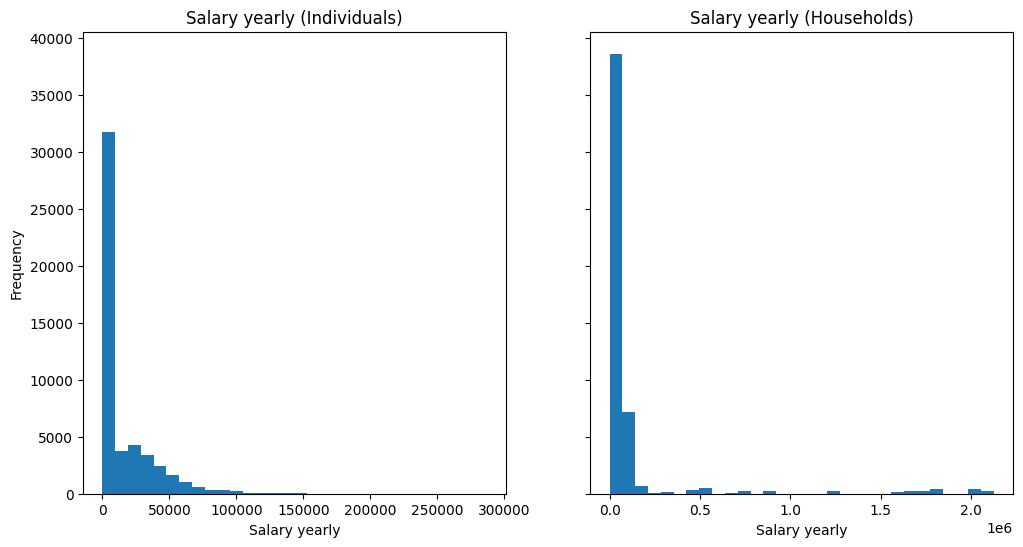

Individuals in SPC = 50000
Individuals without reported income = 30056
% of individuals with reported income = 39.9
Individuals with reported income: 0 = 0
Households in SPC = 21569
Households without reported income = 14653
% of households with reported income = 67.9
Households with reported income: 0 = 14653


In [14]:
# histogram for individuals and households (include NAs as 0)
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax[0].hist(spc_edited['salary_yearly'].fillna(0), bins=30)
ax[0].set_title('Salary yearly (Individuals)')
ax[0].set_xlabel('Salary yearly')
ax[0].set_ylabel('Frequency')
ax[1].hist(spc_edited['salary_yearly_hh'].fillna(0), bins=30)
ax[1].set_title('Salary yearly (Households)')
ax[1].set_xlabel('Salary yearly')
plt.show()


# statistics

# print the total number of rows in the spc. Add a message "Values ="
print("Individuals in SPC =", spc_edited.shape[0])
# number of individuals without reported income
print("Individuals without reported income =", spc_edited['salary_yearly'].isna().sum())
# % of individuals with reported income (salary_yearly not equal NA)
print("% of individuals with reported income =", round((spc_edited['salary_yearly'].count() / spc_edited.shape[0]) * 100, 1))
print("Individuals with reported income: 0 =", spc_edited[spc_edited['salary_yearly'] == 0].shape[0])


# print the total number of households
print("Households in SPC =", spc_edited['household'].nunique())
# number of households without reported income (salary yearly_hh = 0)
print("Households without reported income =", spc_edited[spc_edited['salary_yearly_hh'] == 0].shape[0])
# # % of households with reported income (salary_yearly not equal NA)
print("% of households with reported income =", round((spc_edited[spc_edited['salary_yearly_hh'] == 0].shape[0] / spc_edited['household'].nunique()) * 100, 1))
print("Households with reported income: 0 =", spc_edited[spc_edited['salary_yearly_hh'] == 0].shape[0])


In [15]:
# --- Recode column so that it matches the reported NTS values (Use income_dict_nts_hh dictionary for reference)

# Define the bins (first )
bins = [0, 24999, 49999, np.inf]
# Define the labels for the bins
labels = [1, 2, 3]

spc_edited = spc_edited.copy()

spc_edited['salary_yearly_hh_cat'] = (pd.cut(spc_edited['salary_yearly_hh'], bins=bins, labels=labels, include_lowest=True)
                                       .astype('str')
                                       .astype('float'))


# replace NA values with -8 (to be consistent with NTS)
spc_edited['salary_yearly_hh_cat'] = spc_edited['salary_yearly_hh_cat'].fillna(-8)

# Convert the column to int
spc_edited['salary_yearly_hh_cat'] = spc_edited['salary_yearly_hh_cat'].astype('int')

If we compare household income from the SPC and the NTS, we find that the SPC has many more households with no reported income (-8). This will create an issue when matching using household income

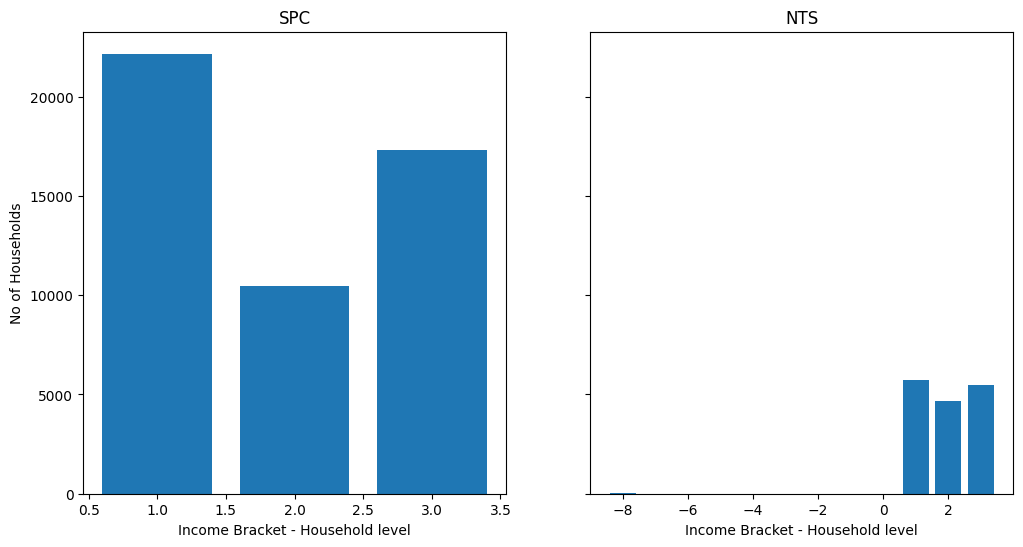

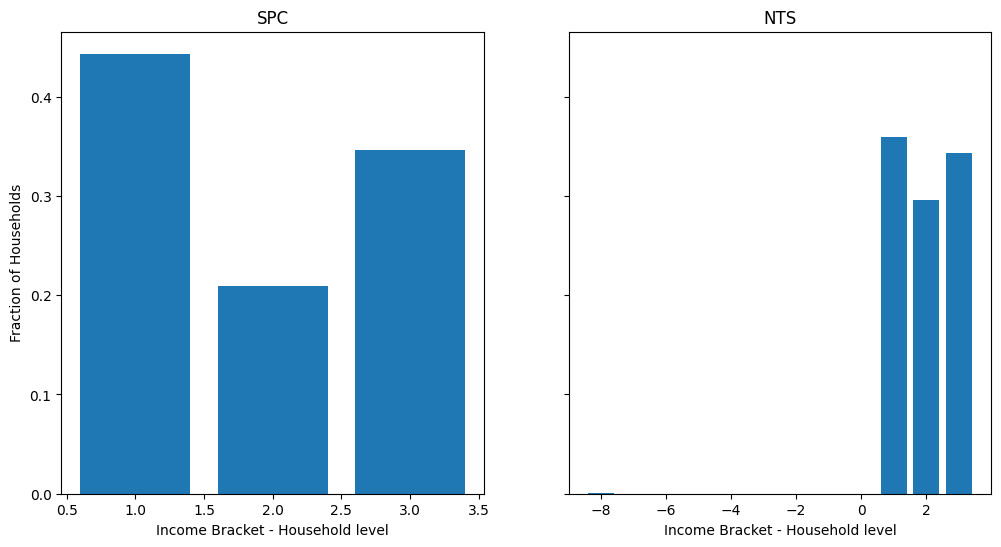

In [16]:
# bar plot showing spc_edited.salary_yearly_hh_cat and nts_households.HHIncome2002_B02ID side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax[0].bar(spc_edited['salary_yearly_hh_cat'].value_counts().index, spc_edited['salary_yearly_hh_cat'].value_counts().values)
ax[0].set_title('SPC')
ax[0].set_xlabel('Income Bracket - Household level')
ax[0].set_ylabel('No of Households')
ax[1].bar(nts_households['HHIncome2002_B02ID'].value_counts().index, nts_households['HHIncome2002_B02ID'].value_counts().values)
ax[1].set_title('NTS')
ax[1].set_xlabel('Income Bracket - Household level')
plt.show()

# same as above but (%)
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax[0].bar(spc_edited['salary_yearly_hh_cat'].value_counts(normalize=True).index, spc_edited['salary_yearly_hh_cat'].value_counts(normalize=True).values)
ax[0].set_title('SPC')
ax[0].set_xlabel('Income Bracket - Household level')
ax[0].set_ylabel('Fraction of Households')
ax[1].bar(nts_households['HHIncome2002_B02ID'].value_counts(normalize=True).index, nts_households['HHIncome2002_B02ID'].value_counts(normalize=True).values)
ax[1].set_title('NTS')
ax[1].set_xlabel('Income Bracket - Household level')
plt.show()

In [17]:
# get the % of households in each income bracket for the nts
nts_households['HHIncome2002_B02ID'].value_counts(normalize=True) * 100

HHIncome2002_B02ID
 1.0    35.969773
 3.0    34.382872
 2.0    29.559194
-8.0     0.088161
Name: proportion, dtype: float64

#### Household Composition (No. of Adults / Children)

In [18]:
# Number of adults and children in the household

spc_edited = num_adult_child_hh(data = spc_edited,
                                group_col = 'household',
                                age_col = 'age_years')

#### Employment Status

In [19]:
# Employment status

# check the colums values from our dictionary
dict_spc['pwkstat'], dict_nts['HHoldEmploy_B01ID']

({'0': 'Not applicable (age < 16)',
  '1': 'Employee FT',
  '2': 'Employee PT',
  '3': 'Employee unspecified',
  '4': 'Self-employed',
  '5': 'Unemployed',
  '6': 'Retired',
  '7': 'Homemaker/Maternal leave',
  '8': 'Student',
  '9': 'Long term sickness/disability',
  '10': 'Other'},
 {'1': 'None',
  '2': '0 FT, 1 PT',
  '3': '1 FT, 0 PT',
  '4': '0 FT, 2 PT',
  '5': '1 FT, 1 PT',
  '6': '2 FT, 0 PT',
  '7': '1 FT, 2+ PT',
  '8': '2 FT, 1+ PT',
  '9': '0 FT, 3+ PT',
  '10': '3+ FT, 0 PT',
  '11': '3+ FT, 1+ PT',
  '-8': 'NA',
  '-10': 'DEAD'})

The NTS only reports the number of Full time and Part time employees for each household. For the SPC we also need to get the number of full time and part time workers for each household.

Step 1: Create a column for Full time and a column for Part time

In [20]:
# We will only use '1' and '2' for the employment status

counts_df = count_per_group(df = spc_edited,
                            group_col = 'household',
                            count_col = 'pwkstat',
                            values=[1, 2],
                            value_names=['pwkstat_FT_hh','pwkstat_PT_hh'])

counts_df.head(10)

,pwkstat_FT_hh,pwkstat_PT_hh
household,,
0,0,0
1,0,0
2,2,0
3,1,0
4,0,0
5,1,0
6,0,0
7,1,0
8,1,0


Create a column that matches the NTS categories (m FT, n PT)

In [21]:
# We want to match the SPC values to the NTS
dict_nts['HHoldEmploy_B01ID']
'''
{
    '1': 'None',
    '2': '0 FT, 1 PT',
    '3': '1 FT, 0 PT',
    '4': '0 FT, 2 PT',
    '5': '1 FT, 1 PT',
    '6': '2 FT, 0 PT',
    '7': '1 FT, 2+ PT',
    '8': '2 FT, 1+ PT',
    '9': '0 FT, 3+ PT',
    '10': '3+ FT, 0 PT',
    '11': '3+ FT, 1+ PT',
    '-8': 'NA',
    '-10': 'DEAD'}
 '''

# 1) Match each row to the NTS

# Define the conditions and outputs.
# We are using the keys in dict_nts['HHoldEmploy_B01ID'] as reference
conditions = [
    (counts_df['pwkstat_FT_hh'] == 0) & (counts_df['pwkstat_PT_hh'] == 0),
    (counts_df['pwkstat_FT_hh'] == 0) & (counts_df['pwkstat_PT_hh'] == 1),
    (counts_df['pwkstat_FT_hh'] == 1) & (counts_df['pwkstat_PT_hh'] == 0),
    (counts_df['pwkstat_FT_hh'] == 0) & (counts_df['pwkstat_PT_hh'] == 2),
    (counts_df['pwkstat_FT_hh'] == 1) & (counts_df['pwkstat_PT_hh'] == 1),
    (counts_df['pwkstat_FT_hh'] == 2) & (counts_df['pwkstat_PT_hh'] == 0),
    (counts_df['pwkstat_FT_hh'] == 1) & (counts_df['pwkstat_PT_hh'] >= 2),
    (counts_df['pwkstat_FT_hh'] == 2) & (counts_df['pwkstat_PT_hh'] >= 1),
    (counts_df['pwkstat_FT_hh'] == 0) & (counts_df['pwkstat_PT_hh'] >= 3),
    (counts_df['pwkstat_FT_hh'] >= 3) & (counts_df['pwkstat_PT_hh'] == 0),
    (counts_df['pwkstat_FT_hh'] >= 3) & (counts_df['pwkstat_PT_hh'] >= 1)
]

# Define the corresponding outputs based on dict_nts['HHoldEmploy_B01ID]
outputs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# Create a new column using np.select
counts_df['pwkstat_NTS_match'] = np.select(conditions,
                                           outputs,
                                           default= -8)



# 2) merge back onto the spc
spc_edited = spc_edited.merge(counts_df, left_on='household', right_index=True)

# check the output
spc_edited[['household', 'pwkstat', 'pwkstat_FT_hh', 'pwkstat_PT_hh', 'pwkstat_NTS_match']].head(10)


,household,pwkstat,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match
0,0,6,0,0,1
1,1,6,0,0,1
2,1,6,0,0,1
3,2,1,2,0,6
4,2,1,2,0,6
5,3,1,1,0,3
6,4,10,0,0,1
7,4,4,0,0,1
8,4,0,0,0,1
9,5,1,1,0,3


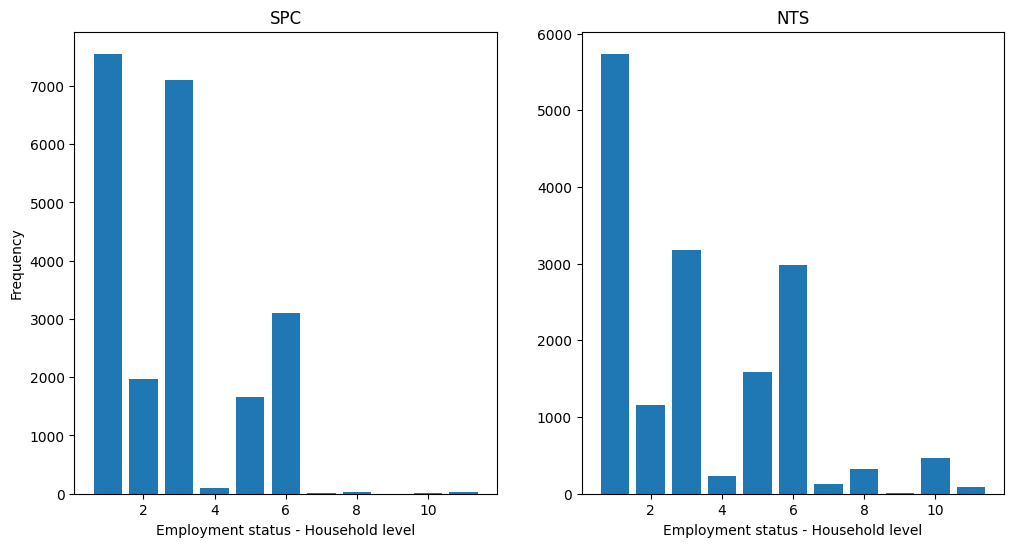

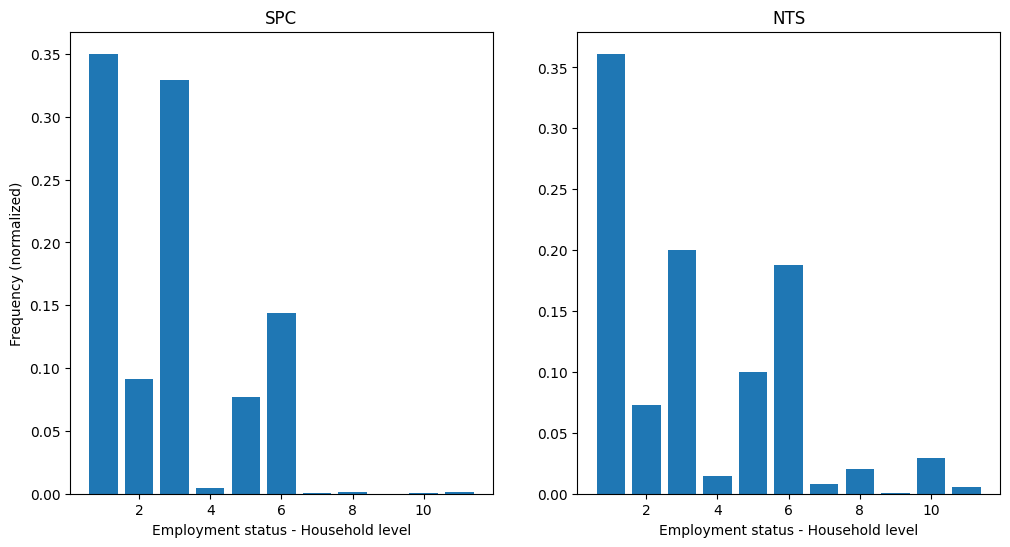

In [22]:
# bar plot of counts_df['pwkstat_NTS_match'] and nts_households['HHoldEmploy_B01ID']
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(counts_df['pwkstat_NTS_match'].value_counts().index, counts_df['pwkstat_NTS_match'].value_counts().values)
ax[0].set_title('SPC')
ax[0].set_xlabel('Employment status - Household level')
ax[0].set_ylabel('Frequency')
ax[1].bar(nts_households['HHoldEmploy_B01ID'].value_counts().index, nts_households['HHoldEmploy_B01ID'].value_counts().values)
ax[1].set_title('NTS')
ax[1].set_xlabel('Employment status - Household level')
plt.show()

# same as above but percentages
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(counts_df['pwkstat_NTS_match'].value_counts().index, counts_df['pwkstat_NTS_match'].value_counts(normalize=True).values)
ax[0].set_title('SPC')
ax[0].set_xlabel('Employment status - Household level')
ax[0].set_ylabel('Frequency (normalized)')
ax[1].bar(nts_households['HHoldEmploy_B01ID'].value_counts().index, nts_households['HHoldEmploy_B01ID'].value_counts(normalize=True).values)
ax[1].set_title('NTS')
ax[1].set_xlabel('Employment status - Household level')
plt.show()



#### Urban Rural Classification

We use the 2011 rural urban classification to match the SPC to the NTS. The NTS has 2 columns that we can use to match to the SPC: `Settlement2011EW_B03ID` and `Settlement2011EW_B04ID`. The `Settlement2011EW_B03ID` column is more general (urban / rural only), while the `Settlement2011EW_B04ID` column is more specific. We stick to the more general column for now.

In [23]:
# read the rural urban classification data
rural_urban = pd.read_csv('../data/external/census_2011_rural_urban.csv', sep=',')

# merge the rural_urban data with the spc
spc_edited = spc_edited.merge(rural_urban[['OA11CD', 'RUC11', 'RUC11CD']], left_on='oa', right_on='OA11CD')
spc_edited.head(5)



,id,household,location,pid_hs,msoa,oa,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD
0,0,0,"{'x': -1.7892179489135742, 'y': 53.91915130615...",2905399,E02002183,E00053954,[0],J,58.0,6,NaN,NaN,E02002183_0001,1.0,NaN,2.0,True,2.0,2,1,86,1,1.0,0.000000,1,1,1,0,0,1,1,0,0,1,E00053954,Urban city and town,C1
1,1,1,"{'x': -1.8262380361557007, 'y': 53.92028045654...",2905308,E02002183,E00053953,"[1, 2]",C,25.0,6,NaN,NaN,E02002183_0002,3.0,NaN,6.0,True,2.0,2,1,74,3,1.0,0.000000,1,1,2,0,0,1,2,0,0,1,E00053953,Urban city and town,C1
2,2,1,"{'x': -1.8262380361557007, 'y': 53.92028045654...",2907681,E02002183,E00053953,"[1, 2]",P,85.0,6,NaN,NaN,E02002183_0002,3.0,NaN,6.0,True,2.0,2,2,68,1,2.0,0.000000,1,1,2,0,0,1,2,0,0,1,E00053953,Urban city and town,C1
3,3,2,"{'x': -1.8749940395355225, 'y': 53.94298934936...",2902817,E02002183,E00053689,"[3, 4]",C,31.0,1,32857.859375,14.360952,E02002183_0003,3.0,NaN,6.0,True,2.0,1,1,27,1,4.0,51020.310547,3,1,2,0,0,0,0,2,0,6,E00053689,Rural town and fringe,D1
4,4,2,"{'x': -1.8749940395355225, 'y': 53.94298934936...",2900884,E02002183,E00053689,"[3, 4]",J,62.0,1,18162.451172,9.439944,E02002183_0003,3.0,NaN,6.0,True,2.0,1,2,26,1,6.0,51020.310547,3,1,2,0,0,0,0,2,0,6,E00053689,Rural town and fringe,D1


In [24]:
# create dictionary from the NTS `Settlement2011EW_B03ID` column
Settlement2011EW_B03ID_nts_hh = {
    '1': 'Urban',
    '2': 'Rural',
    '3': 'Scotland',
    '-8': 'NA',
    '-10': 'DEAD'
}

Settlement2011EW_B04ID_nts_hh = {
    '1': 'Urban Conurbation',
    '2': 'Urban City and Town',
    '3': 'Rural Town and Fringe',
    '4': 'Rural Village, Hamlet and Isolated Dwellings',
    '5': 'Scotland',
    '-8': 'NA',
    '-10': 'DEAD'
}


census_2011_to_nts_B03ID = {
    'Urban major conurbation': 'Urban',
    'Urban minor conurbation': 'Urban',
    'Urban city and town': 'Urban',
    'Urban city and town in a sparse setting': 'Urban',
    'Rural town and fringe': 'Rural',
    'Rural town and fringe in a sparse setting': 'Rural',
    'Rural village': 'Rural',
    'Rural village in a sparse setting': 'Rural',
    'Rural hamlets and isolated dwellings': 'Rural',
    'Rural hamlets and isolated dwellings in a sparse setting': 'Rural'
}

census_2011_to_nts_B04ID = {
    'Urban major conurbation': 'Urban Conurbation',
    'Urban minor conurbation': 'Urban Conurbation',
    'Urban city and town': 'Urban City and Town',
    'Urban city and town in a sparse setting': 'Urban City and Town',
    'Rural town and fringe': 'Rural Town and Fringe',
    'Rural town and fringe in a sparse setting': 'Rural Town and Fringe',
    'Rural village': 'Rural Village, Hamlet and Isolated Dwellings',
    'Rural village in a sparse setting': 'Rural Village, Hamlet and Isolated Dwellings',
    'Rural hamlets and isolated dwellings': 'Rural Village, Hamlet and Isolated Dwellings',
    'Rural hamlets and isolated dwellings in a sparse setting': 'Rural Village, Hamlet and Isolated Dwellings'
}


In [25]:
# add the nts Settlement2011EW_B03ID and Settlement2011EW_B04ID columns to the spc
spc_edited['Settlement2011EW_B03ID_spc'] = spc_edited['RUC11'].map(census_2011_to_nts_B03ID)
spc_edited['Settlement2011EW_B04ID_spc'] = spc_edited['RUC11'].map(census_2011_to_nts_B04ID)
spc_edited.head()

# add the keys from nts_Settlement2011EW_B03ID and nts_Settlement2011EW_B04ID to the spc based on above mappings

# reverse the dictionaries
Settlement2011EW_B03ID_nts_rev = {v: k for k, v in Settlement2011EW_B03ID_nts_hh.items()}
# map the values
spc_edited['Settlement2011EW_B03ID_spc_CD'] = spc_edited['Settlement2011EW_B03ID_spc'].map(Settlement2011EW_B03ID_nts_rev).astype('int')

Settlement2011EW_B04ID_nts_rev = {v: k for k, v in Settlement2011EW_B04ID_nts_hh.items()}
spc_edited['Settlement2011EW_B04ID_spc_CD'] = spc_edited['Settlement2011EW_B04ID_spc'].map(Settlement2011EW_B04ID_nts_rev).astype('int')
spc_edited.head()

,id,household,location,pid_hs,msoa,oa,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD
0,0,0,"{'x': -1.7892179489135742, 'y': 53.91915130615...",2905399,E02002183,E00053954,[0],J,58.0,6,NaN,NaN,E02002183_0001,1.0,NaN,2.0,True,2.0,2,1,86,1,1.0,0.000000,1,1,1,0,0,1,1,0,0,1,E00053954,Urban city and town,C1,Urban,Urban City and Town,1,2
1,1,1,"{'x': -1.8262380361557007, 'y': 53.92028045654...",2905308,E02002183,E00053953,"[1, 2]",C,25.0,6,NaN,NaN,E02002183_0002,3.0,NaN,6.0,True,2.0,2,1,74,3,1.0,0.000000,1,1,2,0,0,1,2,0,0,1,E00053953,Urban city and town,C1,Urban,Urban City and Town,1,2
2,2,1,"{'x': -1.8262380361557007, 'y': 53.92028045654...",2907681,E02002183,E00053953,"[1, 2]",P,85.0,6,NaN,NaN,E02002183_0002,3.0,NaN,6.0,True,2.0,2,2,68,1,2.0,0.000000,1,1,2,0,0,1,2,0,0,1,E00053953,Urban city and town,C1,Urban,Urban City and Town,1,2
3,3,2,"{'x': -1.8749940395355225, 'y': 53.94298934936...",2902817,E02002183,E00053689,"[3, 4]",C,31.0,1,32857.859375,14.360952,E02002183_0003,3.0,NaN,6.0,True,2.0,1,1,27,1,4.0,51020.310547,3,1,2,0,0,0,0,2,0,6,E00053689,Rural town and fringe,D1,Rural,Rural Town and Fringe,2,3
4,4,2,"{'x': -1.8749940395355225, 'y': 53.94298934936...",2900884,E02002183,E00053689,"[3, 4]",J,62.0,1,18162.451172,9.439944,E02002183_0003,3.0,NaN,6.0,True,2.0,1,2,26,1,6.0,51020.310547,3,1,2,0,0,0,0,2,0,6,E00053689,Rural town and fringe,D1,Rural,Rural Town and Fringe,2,3


### 2.2 Edit NTS columns

#### Number of people of pension age

In [26]:
nts_pensioners = count_per_group(df = nts_individuals,
                                 group_col='HouseholdID',
                                 count_col='OfPenAge_B01ID',
                                 values=[1],
                                 value_names=['num_pension_age_nts'])

nts_pensioners.head()

# join onto the nts household df
nts_households = nts_households.merge(nts_pensioners, left_on='HouseholdID', right_index=True, how='left')

#### Number of cars

- `SPC.num_cars` only has values [0, 1, 2]. 2 is for all households with 2 or more cars
- `NTS.NumCar` is more detailed. It has the actual value of the number of cars. We will cap this at 2.

In [27]:

# Create a new column in NTS
nts_households.loc[:, 'NumCar_SPC_match'] = nts_households['NumCar'].apply(truncate_values, upper = 2)

nts_households[['NumCar', 'NumCar_SPC_match']].head(20)

,NumCar,NumCar_SPC_match
142954,1.0,1.0
142955,1.0,1.0
142956,0.0,0.0
142957,2.0,2.0
142958,1.0,1.0
142959,1.0,1.0
142960,2.0,2.0
142961,1.0,1.0
142962,2.0,2.0
142963,1.0,1.0


#### Type of tenancy

Breakdown between NTS and SPC is different. 

In [28]:
dict_nts['Ten1_B02ID'], dict_spc['tenure']

({'1': 'Owns / buying',
  '2': 'Rents',
  '3': 'Other (including rent free)',
  '-8': 'NA',
  '-9': 'DNA',
  '-10': 'DEAD'},
 {'1': 'Owned: Owned outright',
  '2': 'Owned: Owned with a mortgage or loan or shared ownership',
  '3': 'Rented or living rent free: Total',
  '4': 'Rented: Social rented',
  '5': 'Rented: Private rented or living rent free',
  '-8': 'NA',
  '-9': 'DNA',
  '-10': 'DEAD'})

Create dictionaries to map tenure onto the spc and nts dfs

In [29]:
# Dictionary showing how we want the final columns to look like
tenure_dict_nts_spc = {
    1: 'Owned',
    2: 'Rented or rent free',
    -8: 'NA',
    -9: 'DNA',
    -10: 'DEAD'
}

# Matching NTS to tenure_dict_nts_spc

# Create a new dictionary for matching
matching_dict_nts_tenure = {
    1: 1,
    2: 2,
    3: 2
}

matching_dict_spc_tenure = {
    1: 1, #'Owned: Owned outright' : 'Owned'
    2: 1, #'Owned: Owned with a mortgage or loan or shared ownership', : 'Owned'
    3: 2, #'Rented or living rent free: Total', : 'Rented or rent free'
    4: 2, #'Rented: Social rented', : 'Rented or rent free'
    5: 2, #'Rented: Private rented or living rent free', : 'Rented or rent free'
}



map dictionaries to create comparable columns

In [30]:
# Create a new column in nts_households
nts_households['tenure_nts_for_matching'] = (nts_households['Ten1_B02ID']
                                                    .map(matching_dict_nts_tenure) # map the values to the new dictionary
                                                    .fillna(nts_households['Ten1_B02ID'])) # fill the NaNs with the original values

# Create a new column in spc
spc_edited['tenure_spc_for_matching'] = (spc_edited['tenure']
                                        .map(matching_dict_spc_tenure) # map the values to the new dictionary
                                        .fillna(spc_edited['tenure'])) # fill the NaNs with the original values

## Step 3: Matching at Household Level

Now that we've prepared all the columns, we can start matching.

### 3.1 Categorical matching

We will match on (a subset of) the following columns:

| Matching variable | NTS column | SPC column |
| ------------------| ---------- | ---------- |
| Household income  | `HHIncome2002_BO2ID` | `salary_yearly_hh_cat` |
| Number of adults  | `HHoldNumAdults` | `num_adults` |
| Number of children | `HHoldNumChildren` | `num_children` |
| Employment status | `HHoldEmploy_B01ID` | `pwkstat_NTS_match` |
| Car ownership | `NumCar_SPC_match` | `num_cars` |
| Type of tenancy | `tenure_nts_for_matching` | `tenure_spc_for_matching` |
| Rural/Urban Classification | `Settlement2011EW_B03ID` | `Settlement2011EW_B03ID_spc_CD` |

Prepare SPC df for matching

In [31]:
# Select multiple columns
spc_matching = spc_edited[[
    'hid',
    'salary_yearly_hh_cat', 'num_adults',
    'num_children', 'num_pension_age', 'pwkstat_NTS_match',
    'num_cars', 'tenure_spc_for_matching',
    'Settlement2011EW_B03ID_spc_CD', 'Settlement2011EW_B04ID_spc_CD']]

# edit the df so that we have one row per hid
spc_matching = spc_matching.drop_duplicates(subset='hid')

spc_matching.head(10)

,hid,salary_yearly_hh_cat,num_adults,num_children,num_pension_age,pwkstat_NTS_match,num_cars,tenure_spc_for_matching,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD
0,E02002183_0001,1,1,0,1,1,2,1.0,1,2
1,E02002183_0002,1,2,0,2,1,2,1.0,1,2
3,E02002183_0003,3,2,0,0,6,1,1.0,2,3
5,E02002183_0004,2,1,0,0,3,1,1.0,2,3
6,E02002183_0005,1,2,1,1,1,2,1.0,2,3
9,E02002183_0006,3,1,0,0,3,1,2.0,1,2
10,E02002183_0007,1,2,1,2,1,1,1.0,1,2
13,E02002183_0008,2,1,0,0,3,2,1.0,2,4
14,E02002183_0009,1,2,0,0,3,2,1.0,2,4
16,E02002183_0010,1,2,1,0,2,2,1.0,1,2


Prepare NTS df for matching

In [32]:
nts_matching = nts_households[[
    'HouseholdID','HHIncome2002_B02ID',
    'HHoldNumAdults', 'HHoldNumChildren', 'num_pension_age_nts',
    'HHoldEmploy_B01ID', 'NumCar_SPC_match',
    'tenure_nts_for_matching',
    'Settlement2011EW_B03ID', 'Settlement2011EW_B04ID']]

nts_matching.head(10)

,HouseholdID,HHIncome2002_B02ID,HHoldNumAdults,HHoldNumChildren,num_pension_age_nts,HHoldEmploy_B01ID,NumCar_SPC_match,tenure_nts_for_matching,Settlement2011EW_B03ID,Settlement2011EW_B04ID
142954,2019001895,1.0,3,0,2,1,1.0,1.0,1,1
142955,2019002676,1.0,1,0,0,3,1.0,1.0,1,1
142956,2019001891,1.0,2,0,0,1,0.0,2.0,1,1
142957,2019002687,2.0,4,0,0,4,2.0,2.0,1,2
142958,2019001913,1.0,1,0,0,3,1.0,1.0,1,1
142959,2019002273,2.0,1,0,0,3,1.0,2.0,1,1
142960,2019001906,3.0,3,0,0,5,2.0,1.0,1,1
142961,2019001910,1.0,2,0,2,1,1.0,1.0,1,1
142962,2019002688,3.0,2,2,0,6,2.0,1.0,1,2
142963,2019002686,1.0,2,0,2,2,1.0,1.0,1,2


Dictionary of matching columns. We extract column names from this dictioary when matching on a subset of the columns

In [33]:
# column_names (keys) for the dictionary
matching_ids = ['household_id', 'yearly_income', 'number_adults', 'number_children', 'num_pension_age',
                'employment_status', 'number_cars', 'tenure_status', 'rural_urban_2_categories', 'rural_urban_4_categories']

# i want the value to be a list with spc_matching and nts_matching
matching_dfs_dict = {column_name: [spc_value, nts_value] for column_name, spc_value, nts_value in zip(matching_ids, spc_matching, nts_matching)}
matching_dfs_dict

{'household_id': ['hid', 'HouseholdID'],
 'yearly_income': ['salary_yearly_hh_cat', 'HHIncome2002_B02ID'],
 'number_adults': ['num_adults', 'HHoldNumAdults'],
 'number_children': ['num_children', 'HHoldNumChildren'],
 'num_pension_age': ['num_pension_age', 'num_pension_age_nts'],
 'employment_status': ['pwkstat_NTS_match', 'HHoldEmploy_B01ID'],
 'number_cars': ['num_cars', 'NumCar_SPC_match'],
 'tenure_status': ['tenure_spc_for_matching', 'tenure_nts_for_matching'],
 'rural_urban_2_categories': ['Settlement2011EW_B03ID_spc_CD',
  'Settlement2011EW_B03ID'],
 'rural_urban_4_categories': ['Settlement2011EW_B04ID_spc_CD',
  'Settlement2011EW_B04ID']}

Attempt 1: Match on all possible columns

3203 households in the SPC had no match
14.9 % of households in the SPC had no match


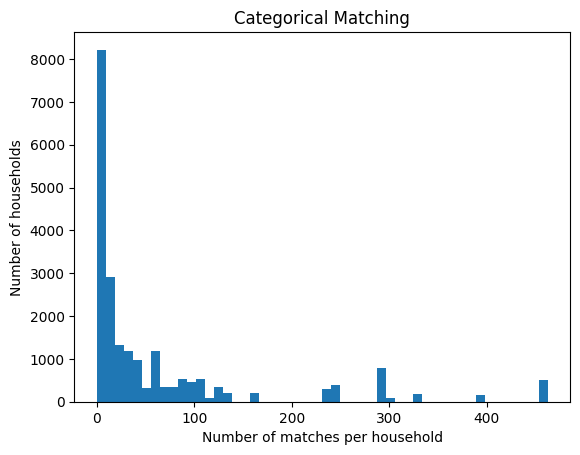

In [34]:
# columns for matching
keys = ['yearly_income', 'number_adults', 'number_children', 'num_pension_age',
        'employment_status', 'number_cars', 'tenure_status', 'rural_urban_2_categories']


spc_cols = [matching_dfs_dict[key][0] for key in keys]
nts_cols = [matching_dfs_dict[key][1] for key in keys]

# match
spc_nts_1 = spc_matching.merge(nts_matching,
                               left_on= spc_cols,
                               right_on= nts_cols,
                               how = 'left')

# Calculate how many rows from nts_matching are matched onto each hid in spc_matching,
spc_nts_1['count'] = spc_nts_1.groupby('hid')['HouseholdID'].transform('count')

spc_nts_1_hist = spc_nts_1.drop_duplicates(subset='hid')


# plot a histogram of the counts and label the axis and title
plt.hist(spc_nts_1_hist['count'], bins=50)
plt.xlabel('Number of matches per household')
plt.ylabel('Number of households')
plt.title('Categorical Matching')

print(spc_nts_1_hist[spc_nts_1_hist['count'] == 0].shape[0], "households in the SPC had no match")
print(round((spc_nts_1_hist[spc_nts_1_hist['count'] == 0].shape[0] / spc_matching['hid'].unique().shape[0]) * 100, 1), "% of households in the SPC had no match")

In [35]:
# calculate matching coverage for all columns

match_coverage_1 = {key: match_coverage_col(data=spc_nts_1,
                                            id_x='hid',
                                            id_y='HouseholdID',
                                            column=matching_dfs_dict[key][0])
                    for key in matching_dfs_dict
            }

# extract any df from the list
match_coverage_1['number_children']



,Total,Matched,Percentage Matched
num_children,,,
0,14302,13760.0,96.0
1,6345,4017.0,63.0
2,764,505.0,66.0
3,136,74.0,54.0
4,19,10.0,53.0
5,2,NaN,NaN
6,1,NaN,NaN


Attempt 2: Match on a subset of columns (exclude salary)

2138 households in the SPC had no match
9.9 % of households in the SPC had no match


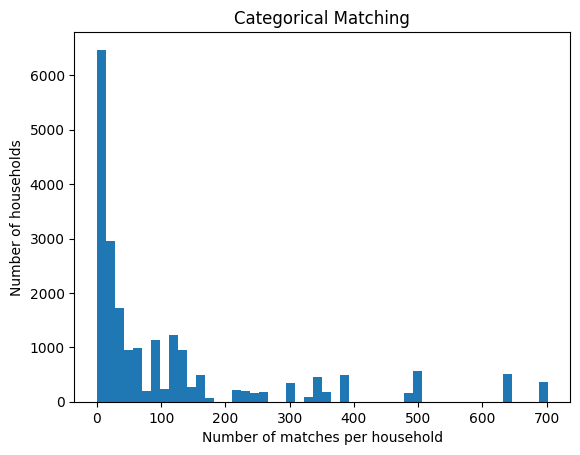

In [36]:
# columns for matching
keys = ['number_adults', 'number_children', 'num_pension_age', 'employment_status',
        'number_cars', 'tenure_status','rural_urban_2_categories']
# extract equivalent column names from dictionary
spc_cols = [matching_dfs_dict[key][0] for key in keys]
nts_cols = [matching_dfs_dict[key][1] for key in keys]

# match
spc_nts_2 = spc_matching.merge(nts_matching,
                               left_on= spc_cols,
                               right_on= nts_cols,
                               how = 'left')

# Calculate how many rows from nts_matching are matched onto each hid in spc_matching,
spc_nts_2['count'] = spc_nts_2.groupby('hid')['HouseholdID'].transform('count')

spc_nts_2_hist = spc_nts_2.drop_duplicates(subset='hid')


# plot a histogram of the counts and label the axis and title
plt.hist(spc_nts_2_hist['count'], bins=50)
plt.xlabel('Number of matches per household')
plt.ylabel('Number of households')
plt.title('Categorical Matching')


print(spc_nts_2_hist[spc_nts_2_hist['count'] == 0].shape[0], "households in the SPC had no match")
print(round((spc_nts_2_hist[spc_nts_2_hist['count'] == 0].shape[0] / spc_matching['hid'].unique().shape[0]) * 100, 1), "% of households in the SPC had no match")

In [37]:
# calculate matching coverage for all columns

match_coverage_2 = {key: match_coverage_col(data=spc_nts_2,
                                            id_x='hid',
                                            id_y='HouseholdID',
                                            column=matching_dfs_dict[key][0])
                    for key in matching_dfs_dict
            }

# extract any df from the list
#match_coverage_2['number_cars']

Attempt 3: Match on a subset of columns (exclude salary and tenure)

1718 households in the SPC had no match
8.0 % of households in the SPC had no match


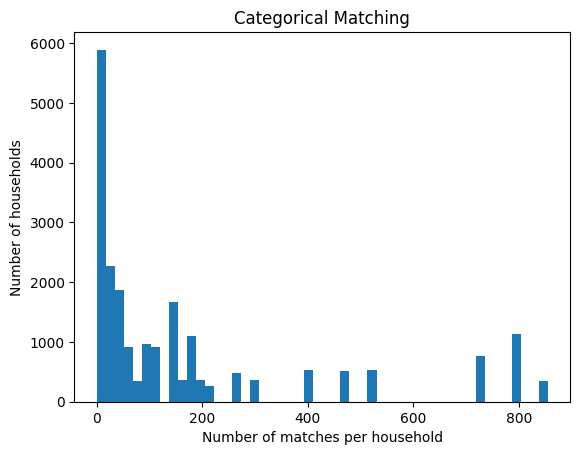

In [38]:

# columns for matching
keys = ['number_adults', 'number_children', 'num_pension_age', 'employment_status',
        'number_cars', 'rural_urban_2_categories']
# extract equivalent column names from dictionary
spc_cols = [matching_dfs_dict[key][0] for key in keys]
nts_cols = [matching_dfs_dict[key][1] for key in keys]

# match
spc_nts_3 = spc_matching.merge(nts_matching,
                               left_on= spc_cols,
                               right_on= nts_cols,
                               how = 'left')

# Calculate how many rows from nts_matching are matched onto each hid in spc_matching,
spc_nts_3['count'] = spc_nts_3.groupby('hid')['HouseholdID'].transform('count')

spc_nts_3_hist = spc_nts_3.drop_duplicates(subset='hid')


# plot a histogram of the counts and label the axis and title
plt.hist(spc_nts_3_hist['count'], bins=50)
plt.xlabel('Number of matches per household')
plt.ylabel('Number of households')
plt.title('Categorical Matching')


print(spc_nts_3_hist[spc_nts_3_hist['count'] == 0].shape[0], "households in the SPC had no match")
print(round((spc_nts_3_hist[spc_nts_3_hist['count'] == 0].shape[0] / spc_matching['hid'].unique().shape[0]) * 100, 1), "% of households in the SPC had no match")


In [39]:
# calculate matching coverage for all columns

match_coverage_3 = {key: match_coverage_col(data=spc_nts_3,
                                            id_x='hid',
                                            id_y='HouseholdID',
                                            column=matching_dfs_dict[key][0])
                    for key in matching_dfs_dict
            }

# extract any df from the list
#match_coverage_2['number_cars']

Attempt 4: Match on a subset of columns (exclude salary, tenure, and employment status)

774 households in the SPC had no match
3.6 % of households in the SPC had no match


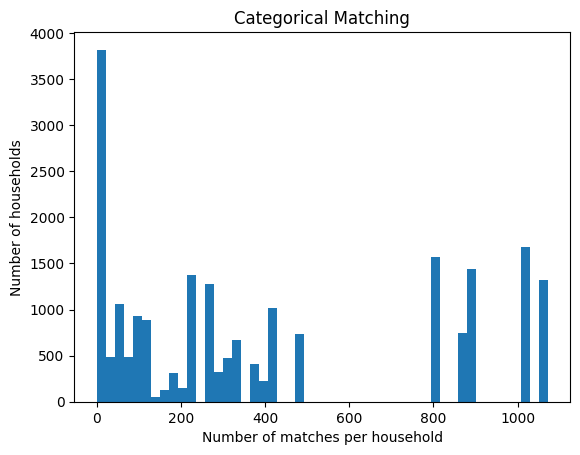

In [40]:

# columns for matching
keys = ['number_adults', 'number_children', 'num_pension_age', 'number_cars', 'rural_urban_2_categories']
# extract equivalent column names from dictionary
spc_cols = [matching_dfs_dict[key][0] for key in keys]
nts_cols = [matching_dfs_dict[key][1] for key in keys]

# matc
spc_nts_4 = spc_matching.merge(nts_matching,
                               left_on= spc_cols,
                               right_on= nts_cols,
                               how = 'left')

# Calculate how many rows from nts_matching are matched onto each hid in spc_matching,
spc_nts_4['count'] = spc_nts_4.groupby('hid')['HouseholdID'].transform('count')

spc_nts_4_hist = spc_nts_4.drop_duplicates(subset='hid')


# plot a histogram of the counts and label the axis and title
plt.hist(spc_nts_4_hist['count'], bins=50)
plt.xlabel('Number of matches per household')
plt.ylabel('Number of households')
plt.title('Categorical Matching')


print(spc_nts_4_hist[spc_nts_4_hist['count'] == 0].shape[0], "households in the SPC had no match")
print(round((spc_nts_4_hist[spc_nts_4_hist['count'] == 0].shape[0] / spc_matching['hid'].unique().shape[0]) * 100, 1), "% of households in the SPC had no match")


In [41]:
# calculate matching coverage for all columns

match_coverage_4 = {key: match_coverage_col(data=spc_nts_4,
                                            id_x='hid',
                                            id_y='HouseholdID',
                                            column=matching_dfs_dict[key][0])
                    for key in matching_dfs_dict
            }

# extract any df from the list
#match_coverage_2['number_cars']

Removing salary has a significant impact on matching

In [42]:
print(spc_matching['hid'].nunique(), "Total households in SPC")

# Attempt 1
print(spc_nts_1_hist[spc_nts_1_hist['count'] == 0].shape[0], "Unmatched households - matching on all categories")
# Attempt 2
print(spc_nts_2_hist[spc_nts_2_hist['count'] == 0].shape[0], "Unmatched households - exclusing Salary from matching")
# Attempt 3
print(spc_nts_3_hist[spc_nts_3_hist['count'] == 0].shape[0], "Unmatched households - exclusing Salary and Tenure from matching")
# Attempt 4
print(spc_nts_4_hist[spc_nts_4_hist['count'] == 0].shape[0], "Unmatched households - exclusing Salary, Tenure and Employment status from matching")

21569 Total households in SPC
3203 Unmatched households - matching on all categories
2138 Unmatched households - exclusing Salary from matching
1718 Unmatched households - exclusing Salary and Tenure from matching
774 Unmatched households - exclusing Salary, Tenure and Employment status from matching


Plot matching coverage for each attempt + variable (key) combination

This will show us, for each matching key, the % of spc households from each unique category that were matched to the NTS

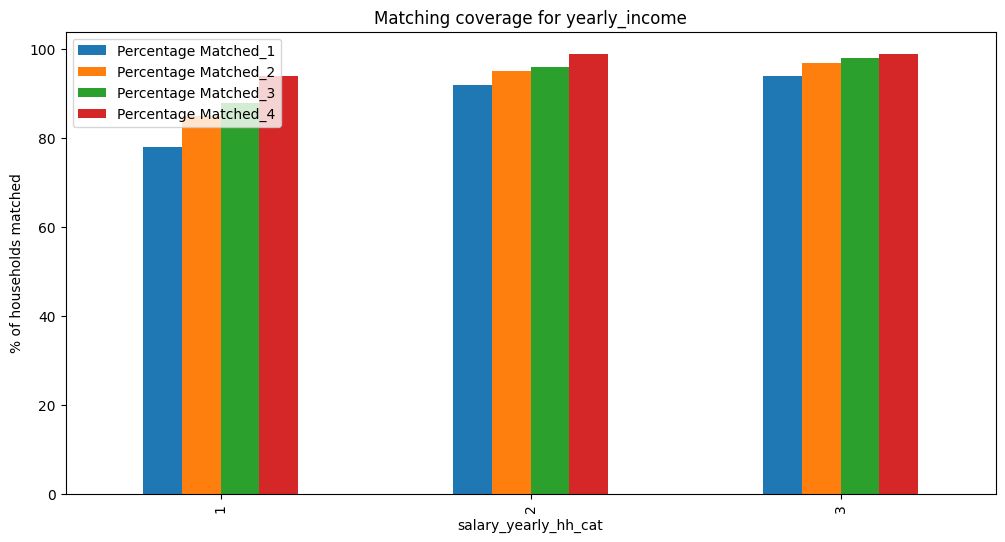

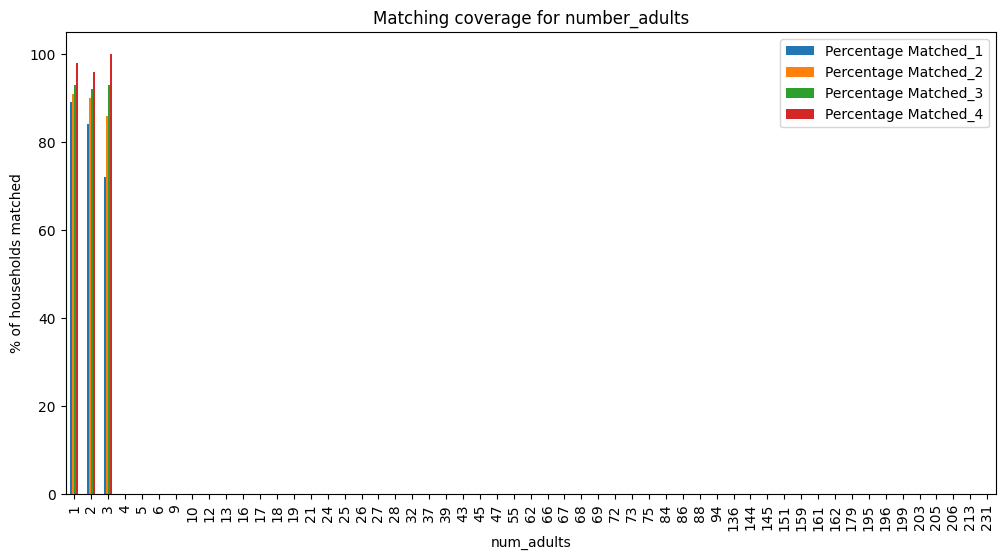

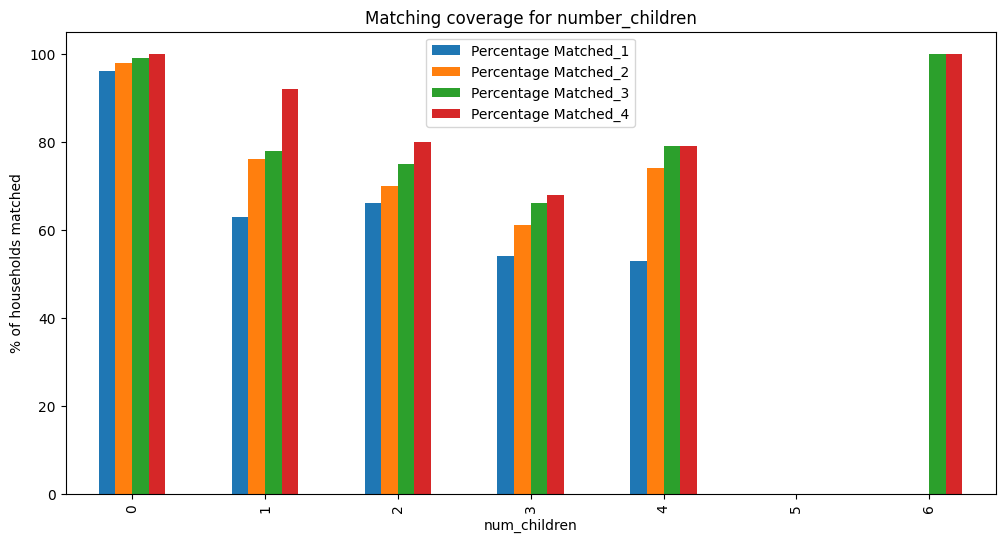

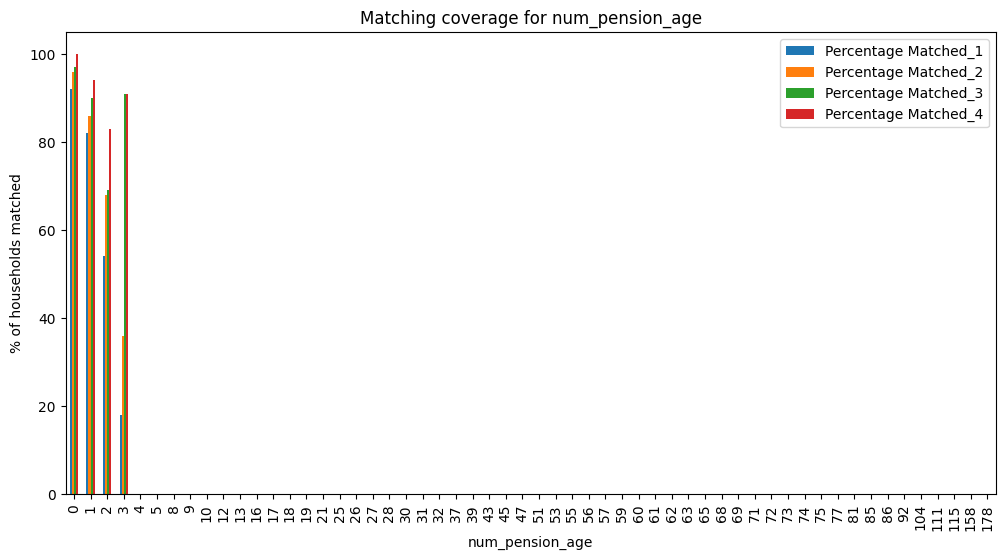

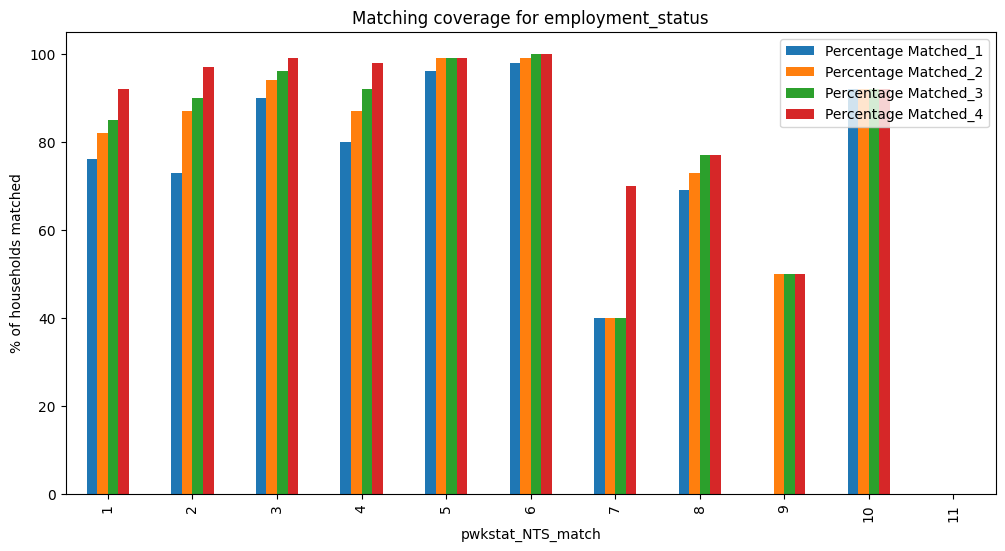

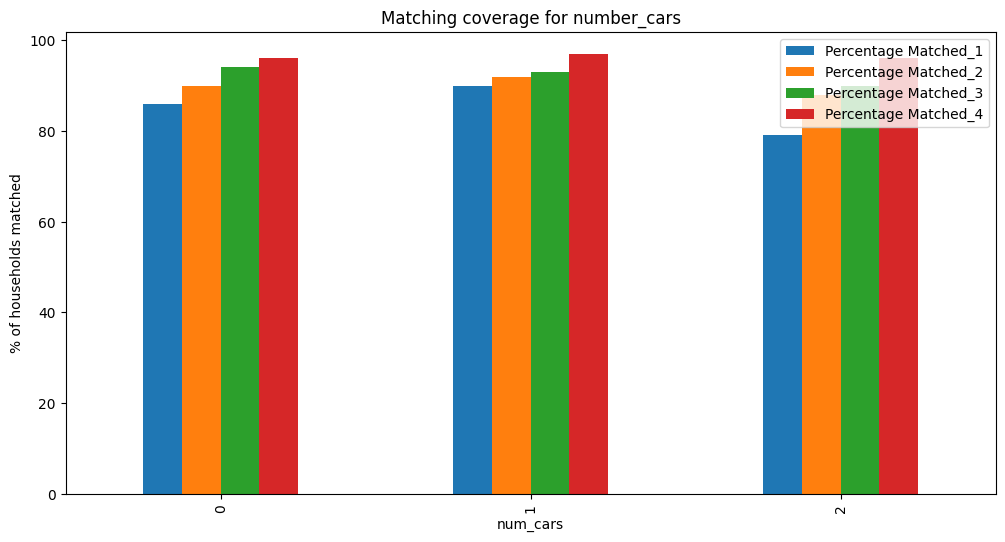

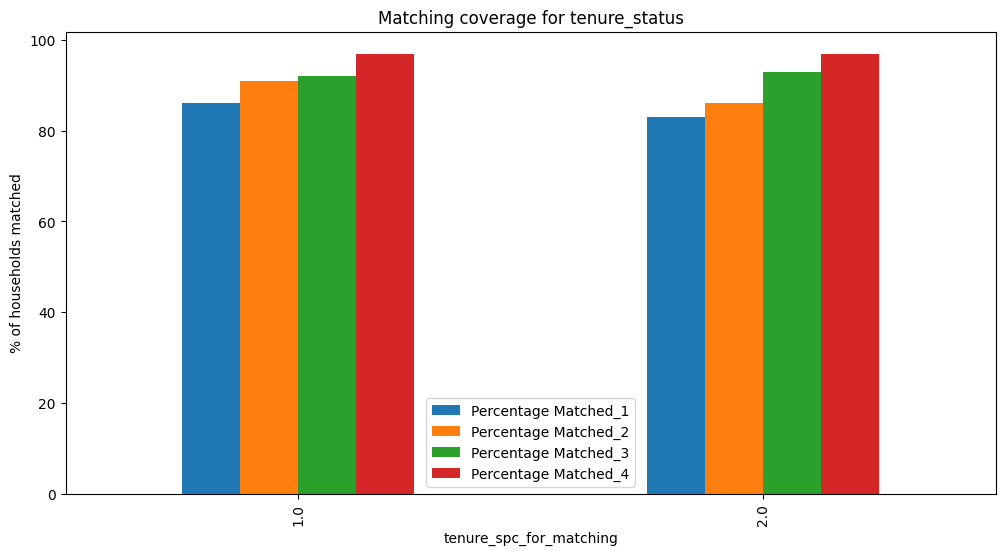

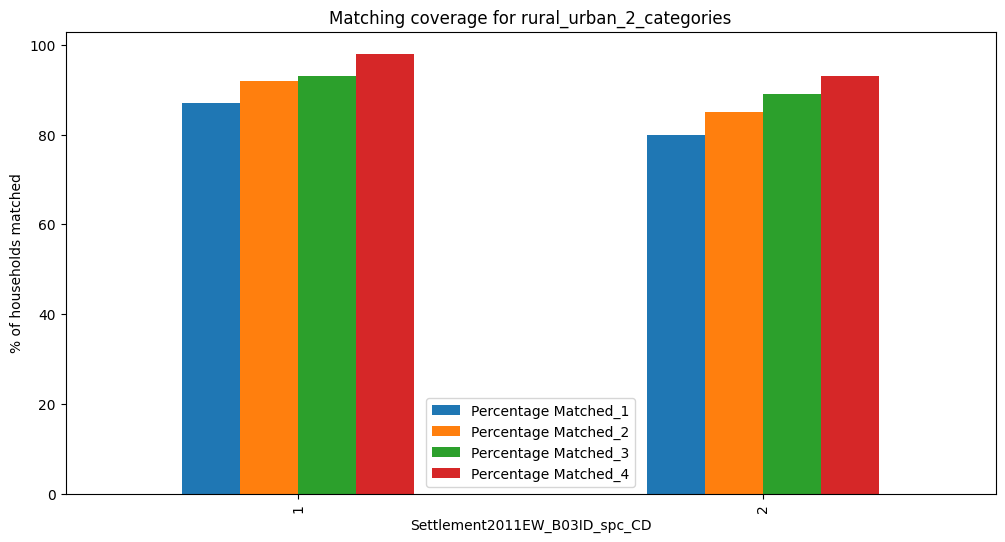

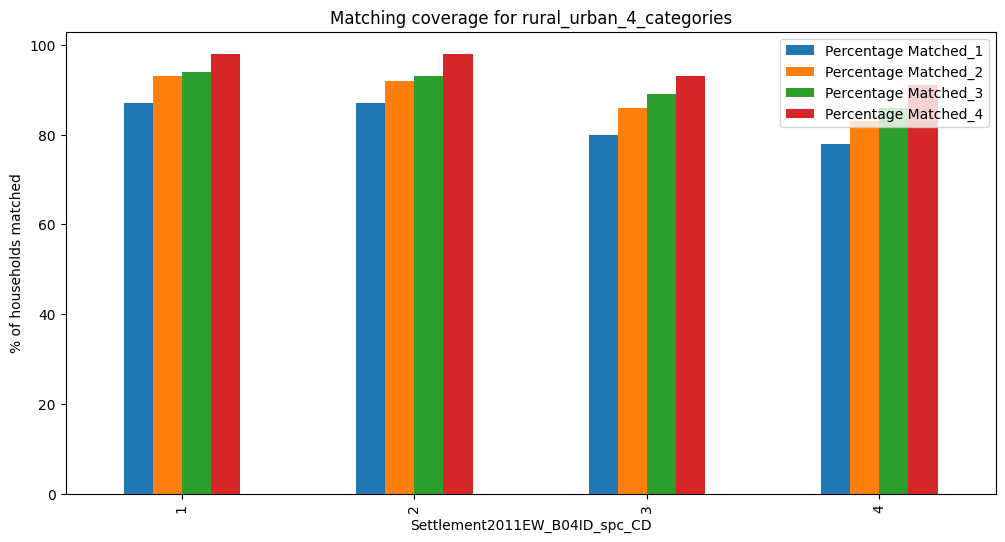

In [43]:
# loop over all variables in matching_dfs_dict and save a plot for each
for key in list(matching_dfs_dict.keys())[1:]:      # skip 1st key (hid)
    x = (match_coverage_1[key]
     .merge(match_coverage_2[key], on=matching_dfs_dict[key][0], suffixes=('_1', '_2'))
     .merge(match_coverage_3[key], on=matching_dfs_dict[key][0], suffixes=('_2', '_3'))
     .merge(match_coverage_4[key], on=matching_dfs_dict[key][0], suffixes=('_3', '_4')))
    # keep % columns only
    x = x[[col for col in x.columns if 'Percentage' in col]]
    # plot bar chart of Percentage of households matched for each category
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    x.plot(kind='bar', ax=ax)
    plt.ylabel('% of households matched')
    plt.title('Matching coverage for ' + key)
    plt.show()
    # save the plot
    fig.savefig(f'../data/interim/matching/plots/matching_coverage_hh_{key}.png')





Plot matching coverage for each attempt + variable (key) combination

This will show us, for each matching key, the % of spc households from each unique category that were matched to the NTS

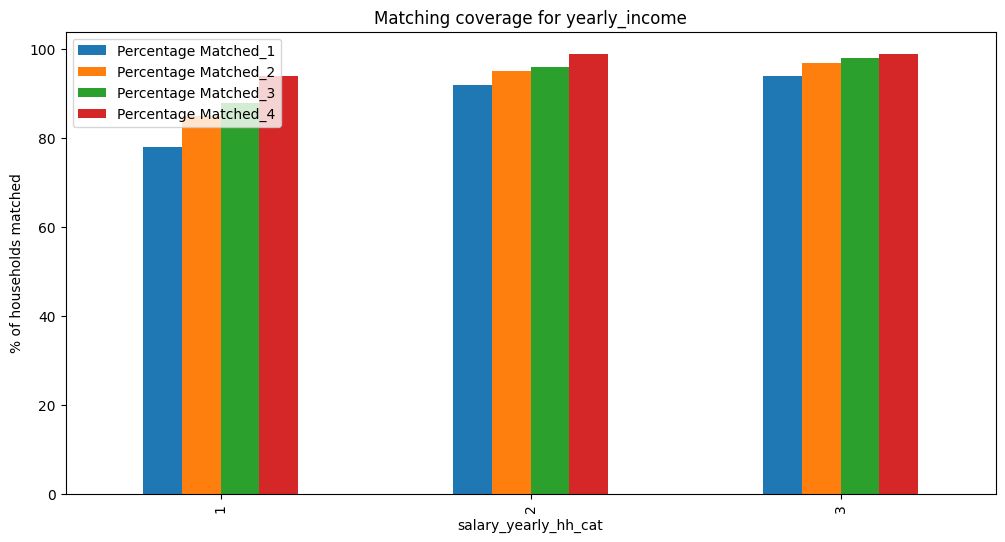

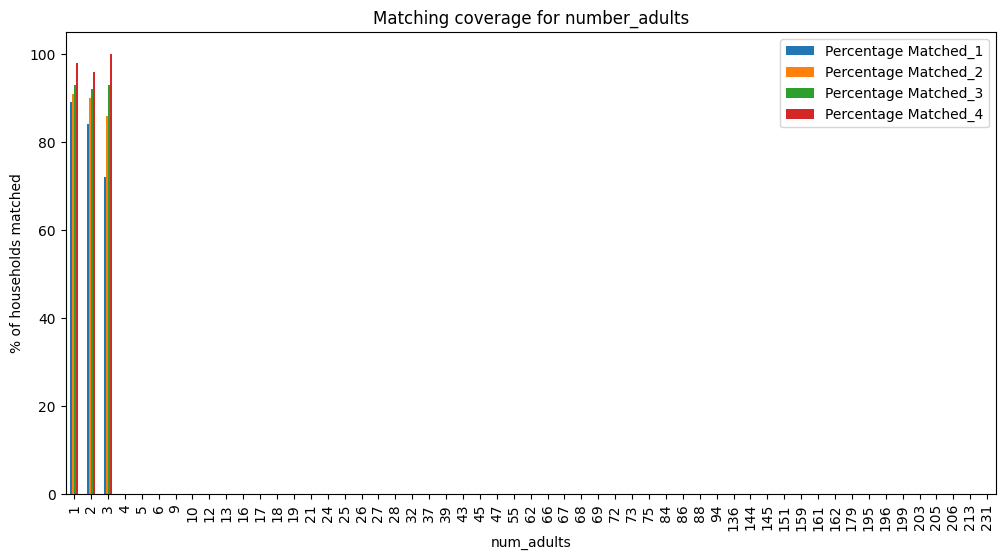

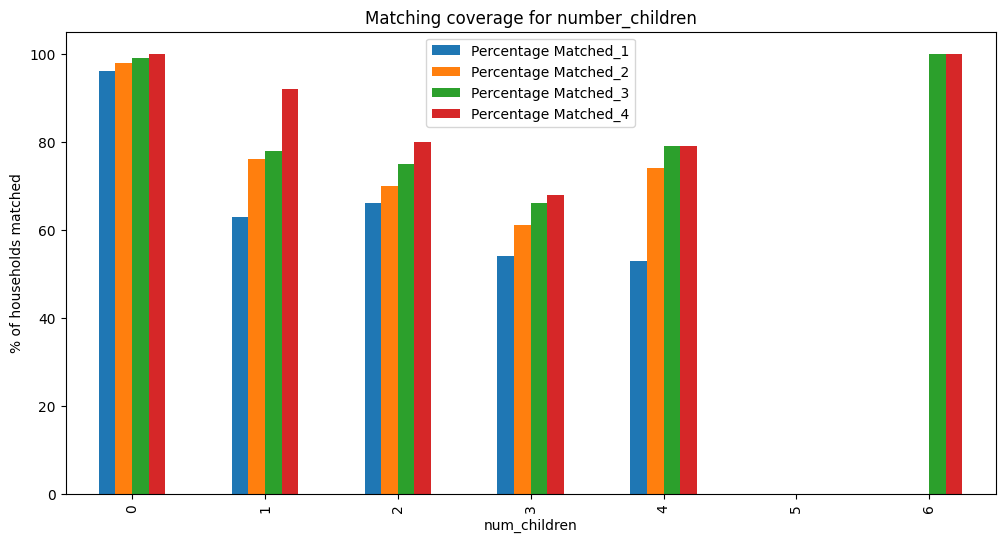

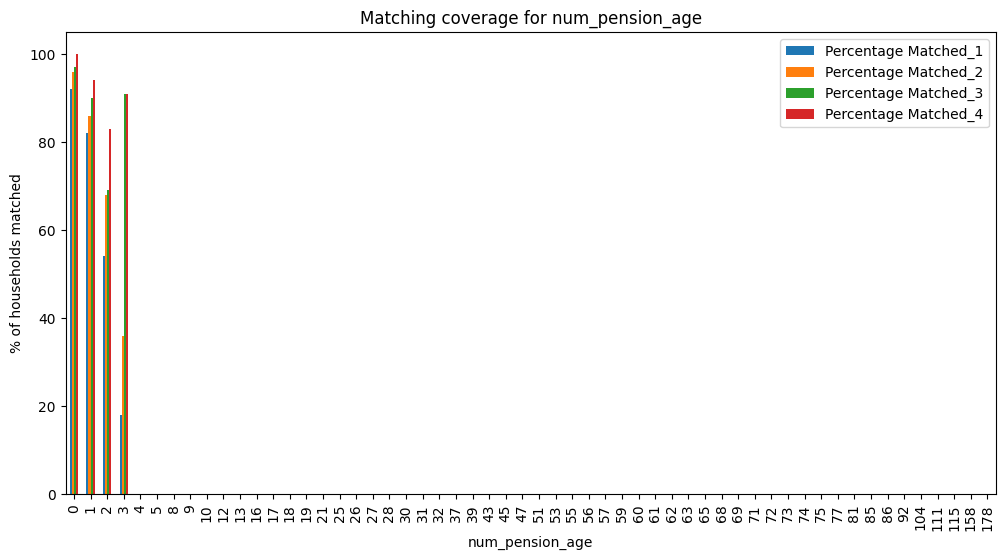

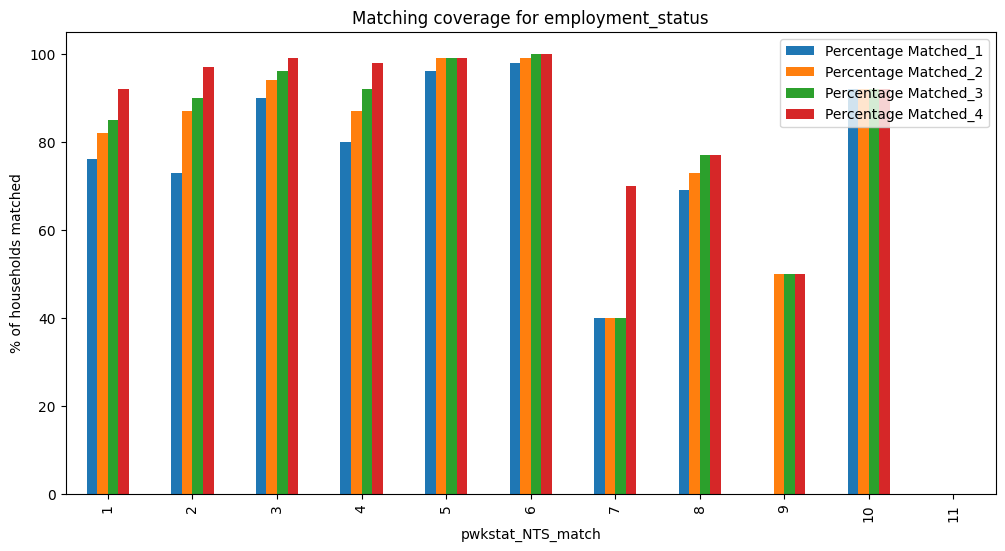

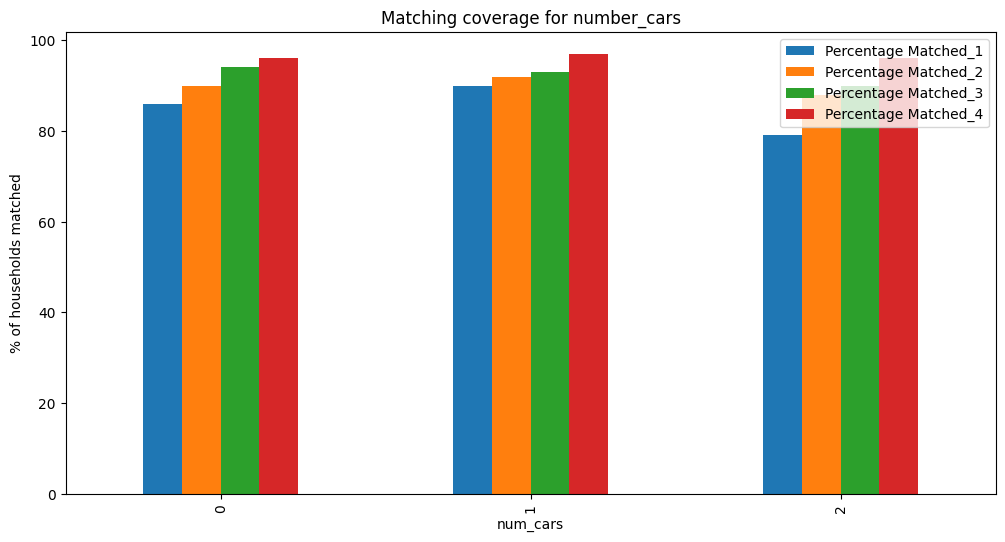

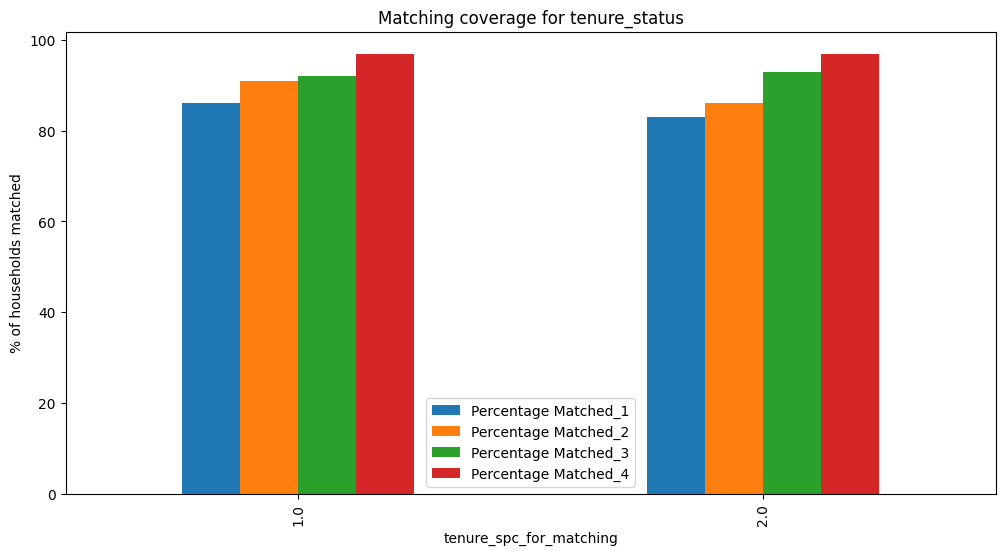

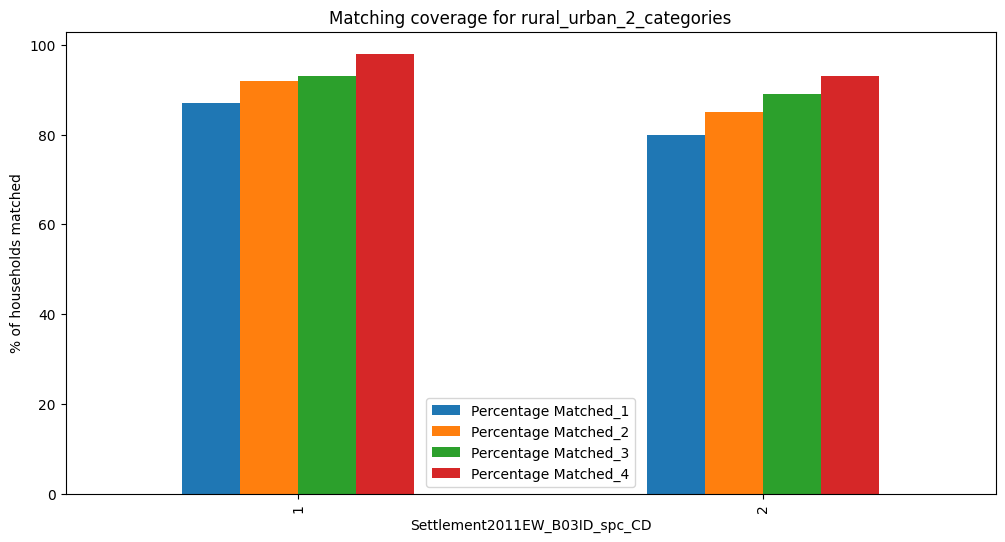

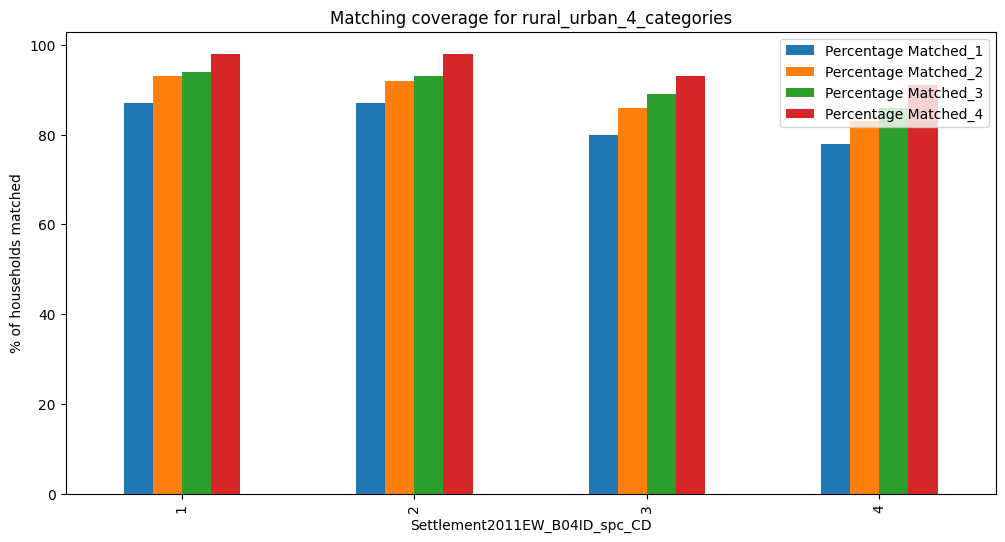

In [44]:
# loop over all variables in matching_dfs_dict and save a plot for each
for key in list(matching_dfs_dict.keys())[1:]:      # skip 1st key (hid)
    x = (match_coverage_1[key]
     .merge(match_coverage_2[key], on=matching_dfs_dict[key][0], suffixes=('_1', '_2'))
     .merge(match_coverage_3[key], on=matching_dfs_dict[key][0], suffixes=('_2', '_3'))
     .merge(match_coverage_4[key], on=matching_dfs_dict[key][0], suffixes=('_3', '_4')))
    # keep % columns only
    x = x[[col for col in x.columns if 'Percentage' in col]]
    # plot bar chart of Percentage of households matched for each category
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    x.plot(kind='bar', ax=ax)
    plt.ylabel('% of households matched')
    plt.title('Matching coverage for ' + key)
    plt.show()
    # save the plot
    fig.savefig(f'../data/interim/matching/plots/matching_coverage_hh_{key}.png')


#### Treat different households differently

Salary is a useful matching variable, so it's a shame not to use it all. We can try to:
- match on salary for households with 0 pensioners
- match without salary for households with one or more pensioners 

1504 households in the SPC had no match
7.0 % of households in the SPC had no match


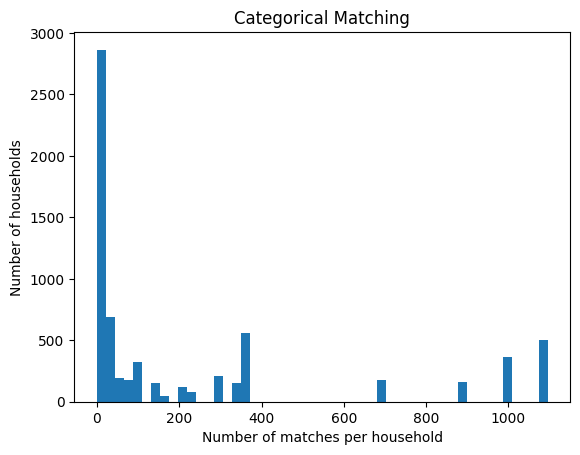

In [45]:
# match on different subset of column depending on yearly_income value
keys = ['yearly_income', 'number_adults', 'number_children', 'num_pension_age',
        'employment_status', 'number_cars', 'tenure_status', 'rural_urban_2_categories']
# remove yearly income from the list
# new list without yearly income, without modifying the original list
keys_no_salary = keys.copy()
keys_no_salary.remove('yearly_income')


#### ------ Split the two datasets into households with no salary and households with a salary

# get spc column name that matches yearly_income in matching_dfs_dict
spc_col = matching_dfs_dict['num_pension_age'][0]
nts_col = matching_dfs_dict['num_pension_age'][1]

# dfs: households with no salary
spc_matching_no_salary = spc_matching[spc_matching[spc_col] > 0]
nts_matching_no_salary = nts_matching[nts_matching[nts_col] > 0]

# dfs: households with a salary
spc_matching_salary = spc_matching[spc_matching[spc_col] != 0]
nts_matching_salary = nts_matching[nts_matching[nts_col] != 0]


#### ------ Match the two datasets separately

# extract equivalent column names from dictionary
spc_cols = [matching_dfs_dict[key][0] for key in keys]
nts_cols = [matching_dfs_dict[key][1] for key in keys]

# extract equivalent column names from dictionary
spc_cols_no_salary = [matching_dfs_dict[key][0] for key in keys_no_salary]
nts_cols_no_salary = [matching_dfs_dict[key][1] for key in keys_no_salary]

# match
spc_nts_no_salary = spc_matching_no_salary.merge(nts_matching_no_salary,
                                                 left_on= spc_cols_no_salary,
                                                 right_on= nts_cols_no_salary,
                                                 how = 'left')

spc_nts_salary = spc_matching_salary.merge(nts_matching_salary,
                                           left_on= spc_cols,
                                           right_on= nts_cols,
                                           how = 'left')

# bind the rows of the two dataframes
spc_nts_x = pd.concat([spc_nts_no_salary, spc_nts_salary])


# Calculate how many rows from nts_matching are matched onto each hid in spc_matching,
spc_nts_x['count'] = spc_nts_x.groupby('hid')['HouseholdID'].transform('count')

spc_nts_x_hist = spc_nts_x.drop_duplicates(subset='hid')


# plot a histogram of the counts and label the axis and title
plt.hist(spc_nts_x_hist['count'], bins=50)
plt.xlabel('Number of matches per household')
plt.ylabel('Number of households')
plt.title('Categorical Matching')


print(spc_nts_x_hist[spc_nts_x_hist['count'] == 0].shape[0], "households in the SPC had no match")
print(round((spc_nts_x_hist[spc_nts_x_hist['count'] == 0].shape[0] / spc_matching['hid'].unique().shape[0]) * 100, 1), "% of households in the SPC had no match")
